# Data Pre-processing

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from warnings import filterwarnings
filterwarnings('ignore')

data = pd.read_excel("data.xlsx")
df = data.copy()

In [31]:
df = df[df["conformity_ec"] == 0]

df_classification = df.drop(["Paper No", "Specimen", "conformity_ec", "hw/lw", "Agb/Ag",
       "v_test", "v_ec8", "Ag"], axis=1)

df_classification.dropna(inplace=True, axis=0)

X_c = df_classification.drop('failure_mode', axis=1)
y_c = df_classification["failure_mode"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.2, random_state=5269)
catb_tuned_c = CatBoostClassifier(depth=5, iterations=100, silent=True).fit(X_train_c, y_train_c)

In [32]:
y_ec8 = df["v_ec8"]

In [33]:
df.drop(["Paper No", "Specimen", "conformity_ec", "v_ec8", "hw/lw", "Ag", 
         "Agb/Ag"], 
        axis=1, inplace=True)

df.shape

(454, 13)

In [34]:
df.isnull().sum()

tw               0
lw               0
hw               0
M/(V.lw)         0
P/(Ag.fc)        0
fc               0
Agb              0
ρbl.fybl         4
ρsh.fysh        20
ρl.fyl           0
ρt.fyt           0
v_test          24
failure_mode     4
dtype: int64

In [35]:
df.dropna(inplace=True, axis=0)
df.shape

(429, 13)

In [36]:
true_failure_mode = pd.DataFrame()
true_failure_mode = df[["failure_mode"]]

In [37]:
X = df.drop(['v_test'], axis=1)
y = df["v_test"]
X.head()

,tw,lw,hw,M/(V.lw),P/(Ag.fc),fc,Agb,ρbl.fybl,ρsh.fysh,ρl.fyl,ρt.fyt,failure_mode
0,150.0,1000,2200.0,2.20,0.00,30.5,30000.0,5.652500,7.395000,2.847500,3.740000,3.0
1,150.0,1400,2000.0,1.43,0.01,46.8,0.0,0.000000,0.000000,4.410368,2.021229,3.0
2,150.0,1400,2000.0,1.43,0.01,46.6,0.0,0.000000,0.000000,7.725619,2.021229,1.0
3,127.0,1625,12000.0,7.38,0.10,49.0,77140.0,2.956163,2.667677,1.219476,1.177428,3.0
4,100.0,700,1600.0,2.50,0.15,27.4,10000.0,14.732880,0.000000,2.673600,2.655481,2.0


In [38]:
cols = X.columns
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=cols)

In [39]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Performances

## LightGBM

In [16]:
randomlist = random.sample(range(1, 10000), 100)

In [18]:
# lgbm parameters were obtained previously using gridsearch cv with 5 fold cross-validation
lgb = LGBMRegressor(n_estimators=300, num_leaves=12, max_depth=4, max_bin=100)
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    lgb.fit(X_train, y_train)
    X_test["failure_mode"] = catb_tuned_c.predict((X_test.iloc[:, :-1]))
    y_pred_train = lgb.predict(X_train)
    y_pred_test = lgb.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9949, (0.0007)
Average Testing R2 Score: 0.9348, (0.0202)
Average Training RMSE: 44.8677, (3.0371)
Average Testing RMSE: 155.2703, (22.9724)
Average Training Mean Absolute Error: 31.0305, (1.899)
Average Testing Mean Absolute Error: 97.9041, (11.3303)
Average Training Mean Absolute Percentage Error: 0.0912, (0.0068)
Average Testing Mean Absolute Percentage Error: 0.2437, (0.0385)
Average Training Prediction Ratio: 1.0023, (0.0039)
Average Testing Prediction Ratio: 1.0425, (0.055)
Average Covariance of Training Prediction Ratios: 0.0258, (0.0058)
Average Covariance of Testing Prediction Ratios: 0.175, (0.0905)
Random state that gives the best testing R2: 1173


In [19]:
df_scores_lgbm = pd.DataFrame()
df_scores_lgbm["R\u00b2"] = r2_scores["testing"]
df_scores_lgbm["RMSE (kN)"] = rmse["testing"]
df_scores_lgbm["MAE (kN)"] = mae["testing"]
df_scores_lgbm["MAPE (%)"] = mape["testing"]
df_scores_lgbm["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_lgbm["COV"] = cov["testing"]

## CatBoost

In [20]:
# catb parameters were obtained previously using gridsearch cv with 5 fold cross-validation
catb = CatBoostRegressor(iterations=500, depth=4, silent=True, loss_function="Poisson")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    catb.fit(X_train, y_train)
    X_test["failure_mode"] = catb_tuned_c.predict((X_test.iloc[:, :-1]))
    y_pred_train = catb.predict(X_train)
    y_pred_test = catb.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9931, (0.0006)
Average Testing R2 Score: 0.9425, (0.0195)
Average Training RMSE: 51.8646, (2.408)
Average Testing RMSE: 145.7768, (25.3659)
Average Training Mean Absolute Error: 38.8163, (1.7708)
Average Testing Mean Absolute Error: 91.9114, (12.7108)
Average Training Mean Absolute Percentage Error: 0.1224, (0.0059)
Average Testing Mean Absolute Percentage Error: 0.2005, (0.0261)
Average Training Prediction Ratio: 1.0551, (0.0041)
Average Testing Prediction Ratio: 1.0618, (0.0372)
Average Covariance of Training Prediction Ratios: 0.0383, (0.0049)
Average Covariance of Testing Prediction Ratios: 0.0893, (0.0316)
Random state that gives the best testing R2: 8839


In [21]:
df_scores_catb = pd.DataFrame()
df_scores_catb["R\u00b2"] = r2_scores["testing"]
df_scores_catb["RMSE (kN)"] = rmse["testing"]
df_scores_catb["MAE (kN)"] = mae["testing"]
df_scores_catb["MAPE (%)"] = mape["testing"]
df_scores_catb["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_catb["COV"] = cov["testing"]

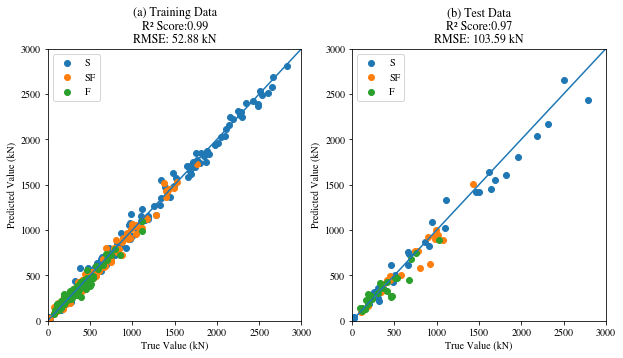

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6859)
X_test["failure_mode"] = catb_tuned_c.predict((X_test.iloc[:, :-1]))
catb_tuned = CatBoostRegressor(iterations=500, depth=4, silent=True, loss_function="Poisson").fit(X_train, y_train)
y_pred_test = catb_tuned.predict(X_test)
y_pred_train = catb_tuned.predict(X_train)

X_test.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

S_index = X_train[X_train["failure_mode"]==1].index
SF_index = X_train[X_train["failure_mode"]==2].index
F_index = X_train[X_train["failure_mode"]==3].index

axs[0].scatter(x=y_train.loc[S_index], y=y_pred_train[S_index])
axs[0].scatter(x=y_train.loc[SF_index], y=y_pred_train[SF_index])
axs[0].scatter(x=y_train.loc[F_index], y=y_pred_train[F_index])
axs[0].legend(["S", "SF", "F"])
axs[0].set_xlim([0, 3000])
axs[0].set_ylim([0, 3000])
axs[0].plot([0,1],[0,1], transform=axs[0].transAxes)
axs[0].set_xlabel('True Value (kN)')
axs[0].set_ylabel("Predicted Value (kN)")
axs[0].set_title(f"(a) Training Data\nR\u00b2 Score:{round(r2_score(y_pred_train, y_train), 2)}\nRMSE: {round(mean_squared_error(y_train, y_pred_train, squared=False), 2)} kN")


S_index = X_test[X_test["failure_mode"]==1].index
SF_index = X_test[X_test["failure_mode"]==2].index
F_index = X_test[X_test["failure_mode"]==3].index

axs[1].scatter(x=y_test.loc[S_index], y=y_pred_test[S_index])
axs[1].scatter(x=y_test.loc[SF_index], y=y_pred_test[SF_index])
axs[1].scatter(x=y_test.loc[F_index], y=y_pred_test[F_index])
axs[1].legend(["S", "SF", "F"])
axs[1].set_xlim([0, 3000])
axs[1].set_ylim([0, 3000])
axs[1].plot([0,1],[0,1], transform=axs[1].transAxes)
axs[1].set_xlabel('True Value (kN)')
axs[1].set_ylabel("Predicted Value (kN)")
axs[1].set_title(f"(b) Test Data\nR\u00b2 Score:{round(r2_score(y_pred_test, y_test), 2)}\nRMSE: {round(mean_squared_error(y_test, y_pred_test, squared=False), 2)} kN")

plt.show()

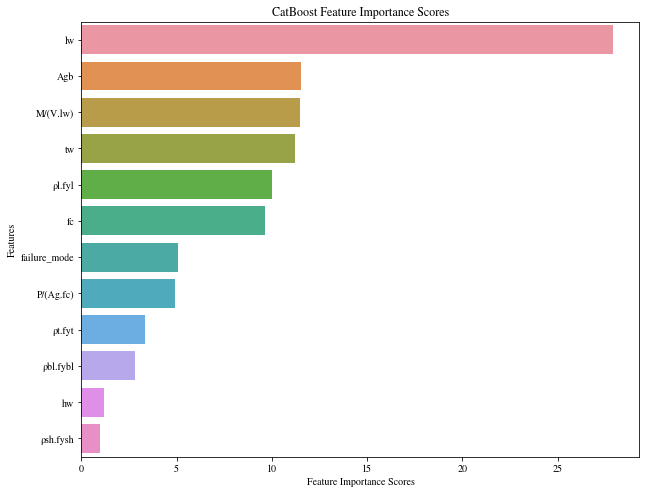

In [28]:
feature_imp = pd.Series(catb_tuned.feature_importances_,
                index=X.columns).sort_values(ascending=False)
plt.figure(figsize = (10, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Scores')
plt.ylabel('Features')
plt.title("CatBoost Feature Importance Scores")
plt.show()

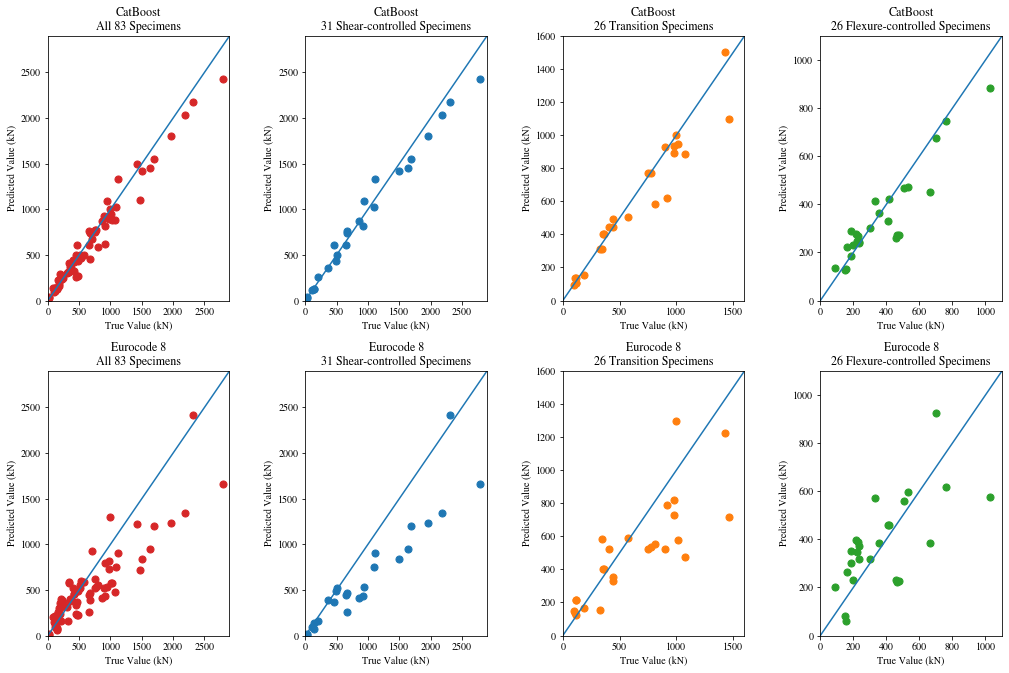

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6859)

fails = true_failure_mode.loc[X_test.index]

y_pred_ec8_all = y_ec8[y_test.index]
y_pred_ec8_all.dropna(inplace=True)
y_pred_catb_all = catb_tuned.predict(X_test.loc[y_pred_ec8_all.index, :])

y_pred_ec8_s = y_ec8[fails[fails["failure_mode"]==1].index]
y_pred_ec8_s.dropna(inplace=True)
y_pred_catb_s = catb_tuned.predict(X_test.loc[y_pred_ec8_s.index, :])

y_pred_ec8_t = y_ec8[fails[fails["failure_mode"]==2].index]
y_pred_ec8_t.dropna(inplace=True)
y_pred_catb_t = catb_tuned.predict(X_test.loc[y_pred_ec8_t.index, :])

y_pred_ec8_f = y_ec8[fails[fails["failure_mode"]==3].index]
y_pred_ec8_f.dropna(inplace=True)
y_pred_catb_f = catb_tuned.predict(X_test.loc[y_pred_ec8_f.index, :])

fig, axs = plt.subplots(2, 4, figsize=(15, 10))
plt.tight_layout(pad=5.0)
axs[0, 0].scatter(y_test.loc[y_pred_ec8_all.index], y_pred_catb_all, s=50, color="tab:red")
axs[0, 0].set_xlim([0, 2900])
axs[0, 0].set_ylim([0, 2900])
axs[0, 0].plot([0,1],[0,1], transform=axs[0, 0].transAxes)
axs[0, 0].set_xlabel('True Value (kN)')
axs[0, 0].set_ylabel("Predicted Value (kN)")
axs[0, 0].set_title("CatBoost\nAll 83 Specimens")

axs[1, 0].scatter(y_test.loc[y_pred_ec8_all.index], y_pred_ec8_all, s=50, color="tab:red")
axs[1, 0].set_xlim([0, 2900])
axs[1, 0].set_ylim([0, 2900])
axs[1, 0].plot([0,1],[0,1], transform=axs[1, 0].transAxes)
axs[1, 0].set_xlabel('True Value (kN)')
axs[1, 0].set_ylabel("Predicted Value (kN)")
axs[1, 0].set_title("Eurocode 8\nAll 83 Specimens")

axs[0, 1].scatter(y_test.loc[y_pred_ec8_s.index], y_pred_catb_s, s=50, color="tab:blue")
axs[0, 1].set_xlim([0, 2900])
axs[0, 1].set_ylim([0, 2900])
axs[0, 1].plot([0,1],[0,1], transform=axs[0, 1].transAxes)
axs[0, 1].set_xlabel('True Value (kN)')
axs[0, 1].set_ylabel("Predicted Value (kN)")
axs[0, 1].set_title("CatBoost\n31 Shear-controlled Specimens")

axs[1, 1].scatter(y_test.loc[y_pred_ec8_s.index], y_pred_ec8_s, s=50, color="tab:blue")
axs[1, 1].set_xlim([0, 2900])
axs[1, 1].set_ylim([0, 2900])
axs[1, 1].plot([0,1],[0,1], transform=axs[1, 1].transAxes)
axs[1, 1].set_xlabel('True Value (kN)')
axs[1, 1].set_ylabel("Predicted Value (kN)")
axs[1, 1].set_title("Eurocode 8\n31 Shear-controlled Specimens")

axs[0, 2].scatter(y_test.loc[y_pred_ec8_t.index], y_pred_catb_t, s=50, color="tab:orange")
axs[0, 2].set_xlim([0, 1600])
axs[0, 2].set_ylim([0, 1600])
axs[0, 2].plot([0,1],[0,1], transform=axs[0, 2].transAxes)
axs[0, 2].set_xlabel('True Value (kN)')
axs[0, 2].set_ylabel("Predicted Value (kN)")
axs[0, 2].set_title("CatBoost\n26 Transition Specimens")

axs[1, 2].scatter(y_test.loc[y_pred_ec8_t.index], y_pred_ec8_t, s=50, color="tab:orange")
axs[1, 2].set_xlim([0, 1600])
axs[1, 2].set_ylim([0, 1600])
axs[1, 2].plot([0,1],[0,1], transform=axs[1, 2].transAxes)
axs[1, 2].set_xlabel('True Value (kN)')
axs[1, 2].set_ylabel("Predicted Value (kN)")
axs[1, 2].set_title("Eurocode 8\n26 Transition Specimens")


axs[0, 3].scatter(y_test.loc[y_pred_ec8_f.index], y_pred_catb_f, s=50, color="tab:green")
axs[0, 3].set_xlim([0, 1100])
axs[0, 3].set_ylim([0, 1100])
axs[0, 3].plot([0,1],[0,1], transform=axs[0, 3].transAxes)
axs[0, 3].set_xlabel('True Value (kN)')
axs[0, 3].set_ylabel("Predicted Value (kN)")
axs[0, 3].set_title("CatBoost\n26 Flexure-controlled Specimens")

axs[1, 3].scatter(y_test.loc[y_pred_ec8_f.index], y_pred_ec8_f, s=50, color="tab:green")
axs[1, 3].set_xlim([0, 1100])
axs[1, 3].set_ylim([0, 1100])
axs[1, 3].plot([0,1],[0,1], transform=axs[1, 3].transAxes)
axs[1, 3].set_xlabel('True Value (kN)')
axs[1, 3].set_ylabel("Predicted Value (kN)")
axs[1, 3].set_title("Eurocode 8\n26 Flexure-controlled Specimens")

plt.show()

## XGBoost

In [45]:
# xgb parameters were obtained previously using gridsearch cv with 5 fold cross-validation
xgb = XGBRegressor(verbosity=0, n_estimators=150, colsample_bytree=0.5, max_depth=4, subsample=0.5, loss_function="RMSE")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    xgb.fit(X_train, y_train)
    X_test["failure_mode"] = catb_tuned_c.predict((X_test.iloc[:, :-1]))
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9957, (0.0005)
Average Testing R2 Score: 0.9369, (0.0202)
Average Training RMSE: 41.1524, (2.1253)
Average Testing RMSE: 152.7223, (23.9283)
Average Training Mean Absolute Error: 30.0632, (1.5581)
Average Testing Mean Absolute Error: 97.5673, (12.2658)
Average Training Mean Absolute Percentage Error: 0.0919, (0.0068)
Average Testing Mean Absolute Percentage Error: 0.2312, (0.0338)
Average Training Prediction Ratio: 1.003, (0.0046)
Average Testing Prediction Ratio: 1.0746, (0.0479)
Average Covariance of Training Prediction Ratios: 0.0275, (0.009)
Average Covariance of Testing Prediction Ratios: 0.144, (0.0668)
Random state that gives the best testing R2: 4207


In [46]:
df_scores_xgb = pd.DataFrame()
df_scores_xgb["R\u00b2"] = r2_scores["testing"]
df_scores_xgb["RMSE (kN)"] = rmse["testing"]
df_scores_xgb["MAE (kN)"] = mae["testing"]
df_scores_xgb["MAPE (%)"] = mape["testing"]
df_scores_xgb["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_xgb["COV"] = cov["testing"]

## SVM

In [ ]:
svm = SVR()

svm_params = {
    'C': [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100, 1000, 10000],
    "kernel":['linear','poly','rbf','sigmoid'],
    "gamma": ["auto", "scale"]
}

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
gs_cv = GridSearchCV(svm,
                    svm_params,
                    cv = 5, 
                    n_jobs = -1, 
                    verbose = 2  
                    ).fit(X_train, y_train)
print(f"Best params: {gs_cv.best_params_}")
svm_tuned = SVR(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = svm_tuned.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

In [47]:
svm = SVR(C=10000, gamma="scale", kernel="rbf")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    svm.fit(X_train, y_train)
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9936, (0.0019)
Average Testing R2 Score: 0.9226, (0.0256)
Average Training RMSE: 49.5117, (8.0856)
Average Testing RMSE: 169.0609, (29.6883)
Average Training Mean Absolute Error: 13.8974, (1.4807)
Average Testing Mean Absolute Error: 99.4727, (14.4436)
Average Training Mean Absolute Percentage Error: 0.0308, (0.0026)
Average Testing Mean Absolute Percentage Error: 0.2488, (0.0562)
Average Training Prediction Ratio: 1.0053, (0.0029)
Average Testing Prediction Ratio: 1.0724, (0.0584)
Average Covariance of Training Prediction Ratios: 0.0074, (0.0015)
Average Covariance of Testing Prediction Ratios: 0.2625, (0.2258)
Random state that gives the best testing R2: 8025


In [48]:
df_scores_svm = pd.DataFrame()
df_scores_svm["R\u00b2"] = r2_scores["testing"]
df_scores_svm["RMSE (kN)"] = rmse["testing"]
df_scores_svm["MAE (kN)"] = mae["testing"]
df_scores_svm["MAPE (%)"] = mape["testing"]
df_scores_svm["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_svm["COV"] = cov["testing"]

## MLP

In [ ]:
mlp = MLPRegressor()

mlp_params = {"alpha": [1, 0.1, 0.01, 0.001], 
              "hidden_layer_sizes": [(5, 5),
                                     (10, 10), 
                                     (10, 10, 10)],
              "solver" : ["lbfgs","adam","sgd"], 
               # lbfgs: quasi-Newton metodu
               # sgd: stochastic gradient descent
               # adam: stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
              "activation": ["tanh","logistic", "relu"]}


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
gs_cv = GridSearchCV(mlp,
                     mlp_params,
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2  
                     ).fit(X_train, y_train)

print(f"Best params: {gs_cv.best_params_}")
mlp_tuned = MLPRegressor(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = mlp_tuned.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

In [56]:
mlp = MLPRegressor(activation="relu", alpha=0.01, hidden_layer_sizes=(10,15,10), solver="lbfgs")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    mlp.fit(X_train, y_train)
    y_pred_train = mlp.predict(X_train)
    y_pred_test = mlp.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9839, (0.0047)
Average Testing R2 Score: 0.8767, (0.1087)
Average Training RMSE: 78.7157, (11.2465)
Average Testing RMSE: 205.4481, (67.44)
Average Training Mean Absolute Error: 56.0625, (7.3304)
Average Testing Mean Absolute Error: 122.4134, (22.6094)
Average Training Mean Absolute Percentage Error: 0.1871, (0.0377)
Average Testing Mean Absolute Percentage Error: 0.3184, (0.0987)
Average Training Prediction Ratio: 1.0711, (0.0374)
Average Testing Prediction Ratio: 1.1386, (0.1077)
Average Covariance of Training Prediction Ratios: 0.1369, (0.1128)
Average Covariance of Testing Prediction Ratios: 0.5213, (1.0638)
Random state that gives the best testing R2: 8316


In [57]:
df_scores_mlp = pd.DataFrame()
df_scores_mlp["R\u00b2"] = r2_scores["testing"]
df_scores_mlp["RMSE (kN)"] = rmse["testing"]
df_scores_mlp["MAE (kN)"] = mae["testing"]
df_scores_mlp["MAPE (%)"] = mape["testing"]
df_scores_mlp["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_mlp["COV"] = cov["testing"]

## Random Forests

In [ ]:
rf = RandomForestRegressor()

rf_params = {"max_depth": [3, 6, 8, 10], 
            "max_features": [2, 5, 8], # The number of features to consider when looking for the best split
            "n_estimators": [50, 100, 150, 200], 
            "min_samples_split": [2, 5, 8, 10]}  # The minimum number of samples required to split an internal node

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gs_cv = GridSearchCV(rf,
                     rf_params,
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2  
                     ).fit(X_train, y_train)
print(f"Best params: {gs_cv.best_params_}")
rf_tuned = RandomForestRegressor(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

In [51]:
rf = RandomForestRegressor(max_depth=10, max_features=5, min_samples_split=2, n_estimators=100)
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
    rf.fit(X_train, y_train)
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.9871, (0.0013)
Average Testing R2 Score: 0.9152, (0.0263)
Average Training RMSE: 71.1219, (3.363)
Average Testing RMSE: 177.6803, (27.9827)
Average Training Mean Absolute Error: 46.0834, (1.7787)
Average Testing Mean Absolute Error: 113.0548, (13.9938)
Average Training Mean Absolute Percentage Error: 0.1076, (0.0056)
Average Testing Mean Absolute Percentage Error: 0.2595, (0.0411)
Average Training Prediction Ratio: 1.0618, (0.0054)
Average Testing Prediction Ratio: 1.1615, (0.0493)
Average Covariance of Training Prediction Ratios: 0.0282, (0.0046)
Average Covariance of Testing Prediction Ratios: 0.1649, (0.0692)
Random state that gives the best testing R2: 9177


In [52]:
df_scores_rf = pd.DataFrame()
df_scores_rf["R\u00b2"] = r2_scores["testing"]
df_scores_rf["RMSE (kN)"] = rmse["testing"]
df_scores_rf["MAE (kN)"] = mae["testing"]
df_scores_rf["MAPE (%)"] = mape["testing"]
df_scores_rf["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_rf["COV"] = cov["testing"]

## Ridge Regression

In [ ]:
lr = Ridge()

lr_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
            'fit_intercept': [True, False],
            'normalize': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
            }

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
gs_cv = GridSearchCV(lr,
                     lr_params,
                     cv = 5, 
                     n_jobs = -1, 
                     verbose = 2  
                     ).fit(X_train, y_train)
print(f"Best params: {gs_cv.best_params_}")
lr_tuned = Ridge(**gs_cv.best_params_).fit(X_train, y_train)
y_pred = lr_tuned.predict(X_test)
    
score = r2_score(y_test, y_pred)
print(f"Accuracy Score: {round(score, 4)}")

In [53]:
lr = Ridge(alpha=0.1, fit_intercept=True, normalize=True, solver="sparse_cg")
r2_scores = {"training": [], "testing": []}
rmse = {"training": [], "testing": []}
mae = {"training": [], "testing": []}
mape = {"training": [], "testing": []}
p_ratio = {"training": [], "testing": []}
cov = {"training": [], "testing": []}

for i in randomlist:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=i)
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    r2_scores["training"].append(r2_score(y_train, y_pred_train))
    r2_scores["testing"].append(r2_score(y_test, y_pred_test))
    rmse["training"].append(mean_squared_error(y_train, y_pred_train, squared=False))
    rmse["testing"].append(mean_squared_error(y_test, y_pred_test, squared=False))
    mae["training"].append(mean_absolute_error(y_train, y_pred_train))
    mae["testing"].append(mean_absolute_error(y_test, y_pred_test))
    mape["training"].append(mean_absolute_percentage_error(y_train, y_pred_train))
    mape["testing"].append(mean_absolute_percentage_error(y_test, y_pred_test))
    p_ratio["training"].append(np.mean(y_pred_train / y_train))
    p_ratio["testing"].append(np.mean(y_pred_test / y_test))
    cov["training"].append(np.cov(y_pred_train / y_train).tolist())
    cov["testing"].append(np.cov(y_pred_test / y_test).tolist())

print(f"Average Training R2 Score: {round(np.mean(r2_scores['training']), 4)}, ({round(np.std(r2_scores['training']), 4)})")
print(f"Average Testing R2 Score: {round(np.mean(r2_scores['testing']), 4)}, ({round(np.std(r2_scores['testing']), 4)})")

print(f"Average Training RMSE: {round(np.mean(rmse['training']), 4)}, ({round(np.std(rmse['training']), 4)})")
print(f"Average Testing RMSE: {round(np.mean(rmse['testing']), 4)}, ({round(np.std(rmse['testing']), 4)})")

print(f"Average Training Mean Absolute Error: {round(np.mean(mae['training']), 4)}, ({round(np.std(mae['training']), 4)})")
print(f"Average Testing Mean Absolute Error: {round(np.mean(mae['testing']), 4)}, ({round(np.std(mae['testing']), 4)})")

print(f"Average Training Mean Absolute Percentage Error: {round(np.mean(mape['training']), 4)}, ({round(np.std(mape['training']), 4)})")
print(f"Average Testing Mean Absolute Percentage Error: {round(np.mean(mape['testing']), 4)}, ({round(np.std(mape['testing']), 4)})")

print(f"Average Training Prediction Ratio: {round(np.mean(p_ratio['training']), 4)}, ({round(np.std(p_ratio['training']), 4)})")
print(f"Average Testing Prediction Ratio: {round(np.mean(p_ratio['testing']), 4)}, ({round(np.std(p_ratio['testing']), 4)})")

print(f"Average Covariance of Training Prediction Ratios: {round(np.mean(cov['training']), 4)}, ({round(np.std(cov['training']), 4)})")
print(f"Average Covariance of Testing Prediction Ratios: {round(np.mean(cov['testing']), 4)}, ({round(np.std(cov['testing']), 4)})")

print("Random state that gives the best testing R2:", randomlist[np.argmax(r2_scores["testing"])])

Average Training R2 Score: 0.785, (0.0087)
Average Testing R2 Score: 0.7542, (0.0386)
Average Training RMSE: 290.7475, (7.3364)
Average Testing RMSE: 305.0756, (31.7608)
Average Training Mean Absolute Error: 212.7055, (5.783)
Average Testing Mean Absolute Error: 223.1534, (19.6619)
Average Training Mean Absolute Percentage Error: 1.0501, (0.0574)
Average Testing Mean Absolute Percentage Error: 1.0833, (0.2996)
Average Training Prediction Ratio: 0.6969, (0.0508)
Average Testing Prediction Ratio: 0.7246, (0.3408)
Average Covariance of Training Prediction Ratios: 7.7246, (1.1915)
Average Covariance of Testing Prediction Ratios: 8.3167, (5.979)
Random state that gives the best testing R2: 7756


In [54]:
df_scores_lr = pd.DataFrame()
df_scores_lr["R\u00b2"] = r2_scores["testing"]
df_scores_lr["RMSE (kN)"] = rmse["testing"]
df_scores_lr["MAE (kN)"] = mae["testing"]
df_scores_lr["MAPE (%)"] = mape["testing"]
df_scores_lr["Vpred / Vtrue"] = p_ratio["testing"]
df_scores_lr["COV"] = cov["testing"]

## Overall Evaluation

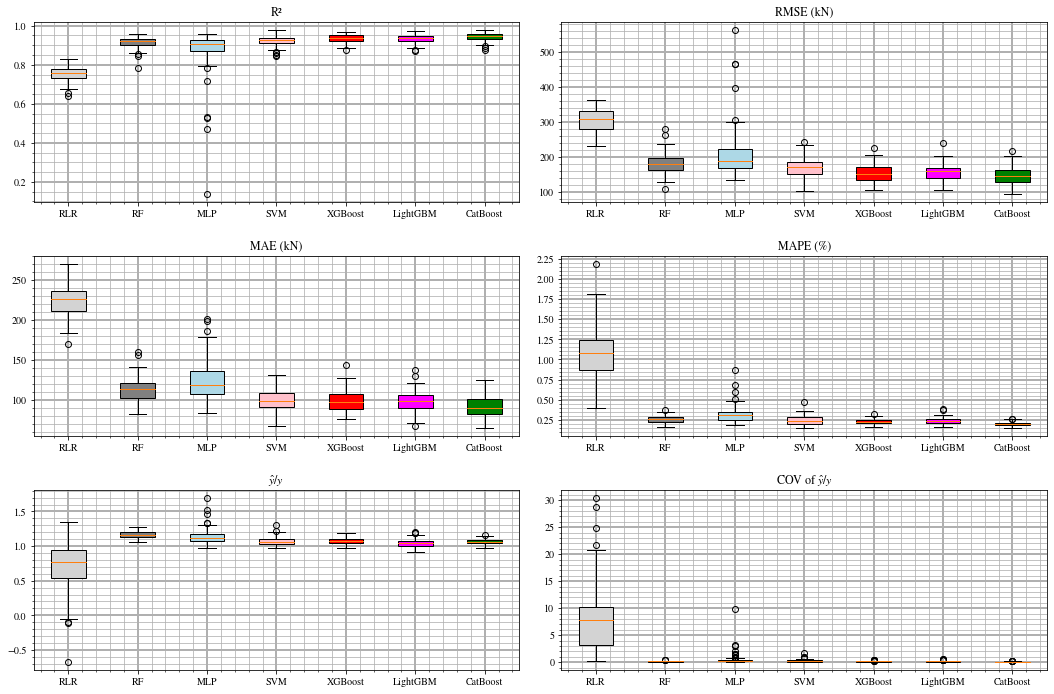

In [58]:
r2_dict = {'RLR': df_scores_lr["R\u00b2"].values, 'RF': df_scores_rf["R\u00b2"].values,
           'MLP': df_scores_mlp["R\u00b2"].values, 'SVM': df_scores_svm["R\u00b2"].values,
           'XGBoost': df_scores_xgb["R\u00b2"].values, 'LightGBM': df_scores_lgbm["R\u00b2"].values,
           'CatBoost': df_scores_catb["R\u00b2"].values,
           }

rmse_dict = {'RLR': df_scores_lr["RMSE (kN)"].values, 'RF': df_scores_rf["RMSE (kN)"].values,
           'MLP': df_scores_mlp["RMSE (kN)"].values, 'SVM': df_scores_svm["RMSE (kN)"].values,
           'XGBoost': df_scores_xgb["RMSE (kN)"].values, 'LightGBM': df_scores_lgbm["RMSE (kN)"].values,
           'CatBoost': df_scores_catb["RMSE (kN)"].values,
           }

mae_dict = {'RLR': df_scores_lr["MAE (kN)"].values, 'RF': df_scores_rf["MAE (kN)"].values,
           'MLP': df_scores_mlp["MAE (kN)"].values, 'SVM': df_scores_svm["MAE (kN)"].values,
           'XGBoost': df_scores_xgb["MAE (kN)"].values, 'LightGBM': df_scores_lgbm["MAE (kN)"].values,
           'CatBoost': df_scores_catb["MAE (kN)"].values,
           }

mape_dict = {'RLR': df_scores_lr["MAPE (%)"].values, 'RF': df_scores_rf["MAPE (%)"].values,
           'MLP': df_scores_mlp["MAPE (%)"].values, 'SVM': df_scores_svm["MAPE (%)"].values,
           'XGBoost': df_scores_xgb["MAPE (%)"].values, 'LightGBM': df_scores_lgbm["MAPE (%)"].values,
           'CatBoost': df_scores_catb["MAPE (%)"].values,
           }

ratio_dict = {'RLR': df_scores_lr["Vpred / Vtrue"].values, 'RF': df_scores_rf["Vpred / Vtrue"].values,
           'MLP': df_scores_mlp["Vpred / Vtrue"].values, 'SVM': df_scores_svm["Vpred / Vtrue"].values,
           'XGBoost': df_scores_xgb["Vpred / Vtrue"].values, 'LightGBM': df_scores_lgbm["Vpred / Vtrue"].values,
           'CatBoost': df_scores_catb["Vpred / Vtrue"].values,
           }

cov_dict = {'RLR': df_scores_lr["COV"].values, 'RF': df_scores_rf["COV"].values,
           'MLP': df_scores_mlp["COV"].values, 'SVM': df_scores_svm["COV"].values,
           'XGBoost': df_scores_xgb["COV"].values, 'LightGBM': df_scores_lgbm["COV"].values,
           'CatBoost': df_scores_catb["COV"].values,
           }

colours = ["lightgray", "gray", "lightblue", "pink", "red", "magenta", "green"]

fig, axs = plt.subplots(3, 2, figsize=(15, 10))

axs[0, 0].set_title("R\u00b2")
bplot1 = axs[0, 0].boxplot(r2_dict.values(), patch_artist=True)
axs[0, 0].set_xticklabels(r2_dict.keys())
axs[0, 0].grid(which="minor", linewidth=0.75)
axs[0, 0].grid(which="major", linewidth=2)
axs[0, 0].minorticks_on()
for patch, color in zip(bplot1['boxes'], colours):
    patch.set_facecolor(color)

axs[0, 1].set_title("RMSE (kN)")
bplot2 = axs[0, 1].boxplot(rmse_dict.values(), patch_artist=True)
axs[0, 1].set_xticklabels(rmse_dict.keys())
axs[0, 1].grid(which="minor", linewidth=0.75)
axs[0, 1].grid(which="major", linewidth=2)
axs[0, 1].minorticks_on()
for patch, color in zip(bplot2['boxes'], colours):
    patch.set_facecolor(color)

axs[1, 0].set_title("MAE (kN)")
bplot3 = axs[1, 0].boxplot(mae_dict.values(), patch_artist=True)
axs[1, 0].set_xticklabels(mae_dict.keys())
axs[1, 0].grid(which="minor", linewidth=0.75)
axs[1, 0].grid(which="major", linewidth=2)
axs[1, 0].minorticks_on()
for patch, color in zip(bplot3['boxes'], colours):
    patch.set_facecolor(color)


axs[1, 1].set_title("MAPE (%)")
bplot4 = axs[1, 1].boxplot(mape_dict.values(), patch_artist=True)
axs[1, 1].set_xticklabels(mape_dict.keys())
axs[1, 1].grid(which="minor", linewidth=0.75)
axs[1, 1].grid(which="major", linewidth=2)
axs[1, 1].minorticks_on()
for patch, color in zip(bplot4['boxes'], colours):
    patch.set_facecolor(color)

axs[2, 0].set_title(r"$\hat{y}/y$")
bplot5 = axs[2, 0].boxplot(ratio_dict.values(), patch_artist=True)
axs[2, 0].set_xticklabels(ratio_dict.keys())
axs[2, 0].grid(which="minor", linewidth=0.75)
axs[2, 0].grid(which="major", linewidth=2)
axs[2, 0].minorticks_on()
for patch, color in zip(bplot5['boxes'], colours):
    patch.set_facecolor(color)

axs[2, 1].set_title(r"COV of $\hat{y}/y$")
bplot6 = axs[2, 1].boxplot(cov_dict.values(), patch_artist=True)
axs[2, 1].set_xticklabels(cov_dict.keys())
axs[2, 1].grid(which="minor", linewidth=0.75)
axs[2, 1].grid(which="major", linewidth=2)
axs[2, 1].minorticks_on()
for patch, color in zip(bplot6['boxes'], colours):
    patch.set_facecolor(color)

plt.tight_layout(pad=2)
plt.show()